알고리즘 체인과 파이프라인
-------

In [1]:
# example code

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import mglearn
import warnings
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import font_manager, rc
warnings.filterwarnings(action='ignore')
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)
matplotlib.rcParams['axes.unicode_minus'] = False

%matplotlib inline

6장에서는 데이터 변환 과정과 머신러닝 모델을 쉽게 연결해주는 Pipeline 파이썬 클래스를 설명
- Pipeline과 GridSearchCV를 함께 사용하여 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행

### 6.1 데이터 전처리와 매개변수 선택

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [6]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

svm = SVC()
svm.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
print(svm.score(X_test_scaled, y_test))

0.951048951048951


In [7]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


위의 코드는 함정이 있다!!
- 데이터의 최솟값과 최대값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용함
- 그런 다음에 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해 그리드 서치 수행
- 교차 검증의 각 분할에서 원본 훈련 세트 데이터의 어떤 부분은 훈련 폴드가 되고 어떤 부분은 검증 폴드가 됨
- 검증 폴드는 훈련 폴드로 학습된 모델이 새로운 데이터에 적용될 때의 성능을 츠겆ㅇ하는 데 사용
- **그러나 데이터 스케일을 조정할 때 검증 폴드에 들어 있는 정보까지 이미 사용**
- **다시 말하면, 교차 검증의 반복마다 선택된 검증 폴드는 전체 훈련 세트의 일부이며, 우리는 데이터의 스케일을 조정하기 위해 전체 훈련 세트를 이용, 하지만 이는 새로운 데이터가 모델에 나타낼 떄와 완전히 다름**

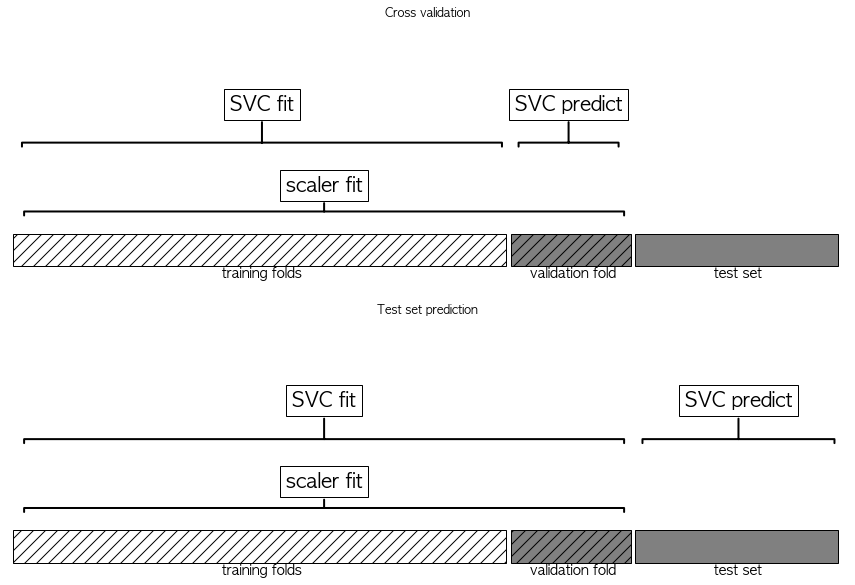

In [8]:
mglearn.plots.plot_improper_processing()


위의 그룹처럼 교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때를 올바로 반영하지 못하고 있음
- 검증 폴드 데이터의 정보가 모델 구축 과정에 이미 알려졌기 때문에 교차 검증에서 최적의 매개변수를 찾기 못함

이를 해결하려면 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄져야 함
- 데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복안에 있어야 함

### 6.2 파이프라인 구축하기

예시로...
- MinMaxScaler로 데이터 스케일 조정
- SVM 모델 사용
- workflow를 Pipeline을 사용해 표현해보겠음

In [10]:
# 각 단계를 리스트로 전달하여 파이프라인 객체를 만듬, 각 단계는 추정기의 객체와 임의의 이름으로 구성된 튜플

from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", MinMaxScaler()), ("svm", SVC())
])

In [11]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [12]:
pipe.score(X_test, y_test)

0.951048951048951

파이프라인에서 score 메서드를 호출하면, 먼저 scaler를 사용하여 테스트 데이터를 변환하고, 변환된 데이터에 SVM 모델의 score 메서드를 호출
- 파이프라인을 사용하면 "전처리 + 분류" 과정을 위해 작성해야 할 코드가 줄어듬
- 파이프라인의 가장 큰 장점은 cross_val_score나 GridSearchCV에 파이프라인을 하나의 추정기처럼 사용할 수 있다는 것

### 6.3 그리드 서치에 파이프라인 적용하기

그리드 서치에 파이프라인을 사용하는 방식 역시 동일
- 탐색할 매개변수 그리드를 정의하고, 이 매개변수 그리드와 파이프라인으로 GridSearchCV의 객체를 만듬
- 매개변수 그리드를 만들 때 조금 달라지는 것이 있다.
- 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야 함
- C와 gamma 매개변수는 두 번째 단계인 SVC의 매개변수는 두 번쨰 단계인 SVC의 매개변수
  - 앞에서 이 단계의 이름을 "svm"으로 지정
  - 파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 "__"(밑줄 문자 2개)로 연결해서 만듬

In [16]:
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}

이 매개변수 그리드로 GridSearchCV를 보통 떄처럼 사용할 수 있게 됨

In [18]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


교차 검증의 각 분할에 MinMaxScaler가 훈련 폴드에 매번 적용되어, 매개벼수 검색 과정에 검증 폴더의 정보가 누설되지 않은 것

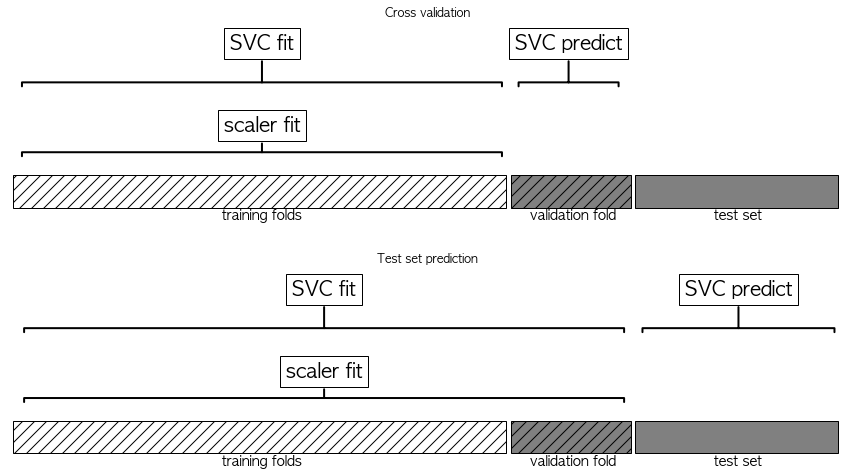

In [19]:
mglearn.plots.plot_proper_processing()

### 6.4 파이프라인 인터페이스

Pipeline은 사실 전처리나 분류에 국한하지 않고 어떤 추정기와도 연결할 수 있다.
- Pipeline에 들어갈 추정기는 마지막 단계를 제외하고는 모두 transform 메서드를 가지고 있어야함
- 그래서 다음 단계를 위한 새로운 데이터 표현을 만들 수 있어야 함

아래와 같은 프로세스로 구현됨

In [20]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [21]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

#### 6.4.1 make_pipeline을 사용한 파이프라인 생성

In [22]:
from sklearn.pipeline import make_pipeline

# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [23]:
pipe_short.steps

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]

- 단계의 이름은 minmaxscaler, svc로 설정됨

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [25]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print(pipe.steps)

[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


- standardscaler-1 / standardscaler-2
- 위의 방식처럼 표현이 됨
- Pipeline을 쓰는 게 더 명시적이다...

#### 6.4.2 단계 속성에 접근하기

파이프라인의 단계 중 하나의 속성을 확인하고 싶을 때!!
- 단계 이름을 키로 가진 딕셔너리인 named_steps 속성을 사용하면 파이프라인의 각 단계에 쉽게 접근할 수 있다.

In [26]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


#### 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

파이프라인을 사용하는 이유는 그리드 서치 때문이다.
- 그래서 그리드 서치 안에 있는 파이프라인의 단계에 접근할 때가 많다.